In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import t
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'

# file_name = 'combined_stock_data.csv'
# file_path = os.path.join(path, file_name)
# df = pd.read_csv(file_path)
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

In [31]:


# Path to the CSV file
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)

# Load the data
df = pd.read_csv(file_path)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Calculating daily returns for stocks and the market
df['stock_return'] = df.groupby('ticker')['stock_adj_close'].pct_change()
df['market_return'] = df['market_adj_close'].pct_change()

# Define the event date and event window
event_date = datetime(2018, 6, 28)
window_start = event_date - timedelta(days=10)
window_end = event_date + timedelta(days=10)

# Filter data for the event window
event_window_data = df[(df['date'] >= window_start) & (df['date'] <= window_end)]

# Function to estimate parameters (alpha and beta) for each stock
def estimate_parameters(ticker, data):
    stock_data = data[data['ticker'] == ticker].dropna()
    if len(stock_data) < 2:  # Ensure there's enough data
        return np.nan, np.nan
    X = sm.add_constant(stock_data['market_return'])  # Adding a constant for the intercept (alpha)
    model = sm.OLS(stock_data['stock_return'], X).fit()
    return model.params

# Estimate parameters for each stock
parameters = {ticker: estimate_parameters(ticker, df) for ticker in df['ticker'].unique()}

# Calculate expected returns for each stock in the event window
def calculate_expected_return(row, params):
    alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
    if pd.isna(alpha) or pd.isna(beta):  # Handle missing alpha or beta
        return np.nan
    return alpha + beta * row['market_return']

event_window_data['expected_return'] = event_window_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)

# Calculate abnormal returns
event_window_data['abnormal_return'] = event_window_data['stock_return'] - event_window_data['expected_return']

# Results
event_window_data[['date', 'ticker', 'stock_return', 'market_return', 'expected_return', 'abnormal_return']]


C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\675090177.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data['expected_return'] = event_window_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\675090177.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data['abnormal_return'] = event_window_data['stock_return'] - event_window_data['expected_return']


,date,ticker,stock_return,market_return,expected_return,abnormal_return
58847,2018-06-18,SAYFF,0.000000,-0.002126,0.007328,-0.007328
58848,2018-06-18,FRRFF,0.000000,0.000000,0.000480,-0.000480
58849,2018-06-18,ABM,-0.009600,0.000000,-0.001061,-0.008539
58850,2018-06-18,ACN,-0.003670,0.000000,0.001251,-0.004920
58851,2018-06-18,AHEXF,0.000000,0.000000,-0.000672,0.000672
...,...,...,...,...,...,...
62354,2018-07-06,APVS,0.000000,0.000000,0.001591,-0.001591
62355,2018-07-06,ASFT,0.000000,0.000000,-0.005463,0.005463
62356,2018-07-06,APCX,0.000000,0.000000,0.016838,-0.016838
62357,2018-07-06,APYP,-0.250000,0.000000,0.012976,-0.262976


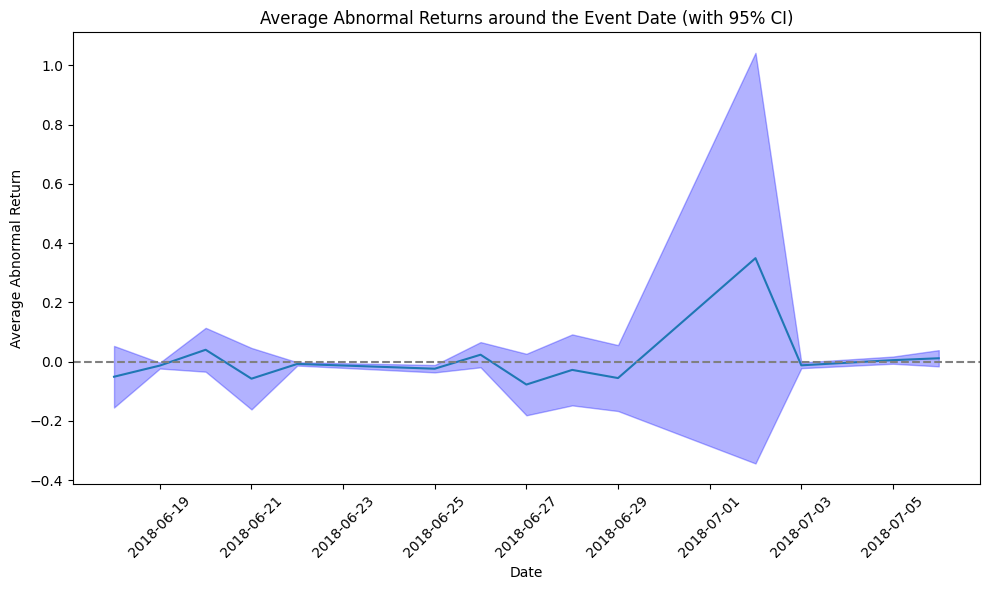

In [32]:


# Assuming event_window_data is your DataFrame from the event study

# Group by date and calculate the mean and standard deviation of abnormal returns for each day
daily_stats = event_window_data.groupby('date')['abnormal_return'].agg(['mean', 'std']).reset_index()

# Calculate the number of observations per day
daily_counts = event_window_data.groupby('date')['abnormal_return'].count().reset_index(name='count')

# Merge the statistics and counts into a single DataFrame
daily_stats = pd.merge(daily_stats, daily_counts, on='date')

# Calculate the standard error of the mean
daily_stats['sem'] = daily_stats['std'] / np.sqrt(daily_stats['count'])

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='mean', data=daily_stats)

# Add shaded region for confidence interval (95% CI)
plt.fill_between(
    daily_stats['date'], 
    daily_stats['mean'] - 1.96 * daily_stats['sem'],  # Lower bound
    daily_stats['mean'] + 1.96 * daily_stats['sem'],  # Upper bound
    color='blue', alpha=0.3
)

plt.axhline(0, color='grey', linestyle='--')  # Zero line for reference
plt.title('Average Abnormal Returns around the Event Date (with 95% CI)')
plt.xlabel('Date')
plt.ylabel('Average Abnormal Return')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout for better look
plt.show()


In [22]:
def run_event_study(df, stock_ticker, event_date):
    # Define windows
    estimation_window_start = event_date - timedelta(days=365)
    estimation_window_end = event_date - timedelta(days=30)
    event_window_start = event_date - timedelta(days=10)
    event_window_end = event_date + timedelta(days=10)

    # Filter the DataFrame for the stock data and calculate returns
    stock_data = df[df['ticker'] == stock_ticker]
    stock_returns = stock_data['stock_adj_close'].pct_change().dropna()

    # Calculate market returns from the 'market_adj_close' column
    market_returns = df['market_adj_close'].pct_change().dropna()

    # Define masks for the estimation and event windows based on stock data index
    estimation_window_mask = (stock_data.index >= estimation_window_start) & (stock_data.index <= estimation_window_end)
    event_window_mask = (stock_data.index >= event_window_start) & (stock_data.index <= event_window_end)

    # Apply masks to the returns
    stock_returns_estimation = stock_returns[estimation_window_mask]
    market_returns_estimation = market_returns[estimation_window_mask]
    
    # Estimate the market model (CAPM)
    X = sm.add_constant(market_returns_estimation)
    model = sm.OLS(stock_returns_estimation, X).fit()

    # Calculate expected and abnormal returns during the event window
    stock_returns_event = stock_returns[event_window_mask]
    market_returns_event = market_returns[stock_data.index.isin(stock_returns_event.index)]
    
    expected_returns = model.params[0] + model.params[1] * market_returns_event
    abnormal_returns = stock_returns_event - expected_returns
    
    # Calculate the average abnormal return
    average_abnormal_return = abnormal_returns.mean()
    print(f"Average Abnormal Return for {stock_ticker}: {average_abnormal_return}")

    return abnormal_returns

# Example usage
unique_tickers = df['ticker'].unique()
event_date = datetime(2018, 6, 28)  # Example event date

# Dictionary to hold abnormal returns for each stock
all_abnormal_returns = {}

for stock_ticker in unique_tickers:
    all_abnormal_returns[stock_ticker] = run_event_study(df, stock_ticker, event_date)

IndexError: Boolean index has wrong length: 258 instead of 257

2017-06-28 00:00:00
date
2017-06-28     27.484063
2017-06-28      0.829718
2017-06-28      2.024576
2017-06-28     -0.527490
2017-06-28     -0.483863
                 ...    
2018-07-06     -0.999921
2018-07-06    537.461528
2018-07-06     -0.464286
2018-07-06     -0.999600
2018-07-06     12.333333
Name: stock_adj_close, Length: 62358, dtype: float64
date
2018-06-18   -1087.208179
2018-06-18   -1124.087351
2018-06-18   -1160.387706
2018-06-18   -1156.172439
2018-06-18   -1161.250886
                 ...     
2018-07-06   -1161.599410
2018-07-06    -623.137961
2018-07-06   -1161.063774
2018-07-06   -1161.599089
2018-07-06   -1148.266155
Length: 3512, dtype: float64


C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\2193647512.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns = model.params[0] + model.params[1] * market_returns[event_window]


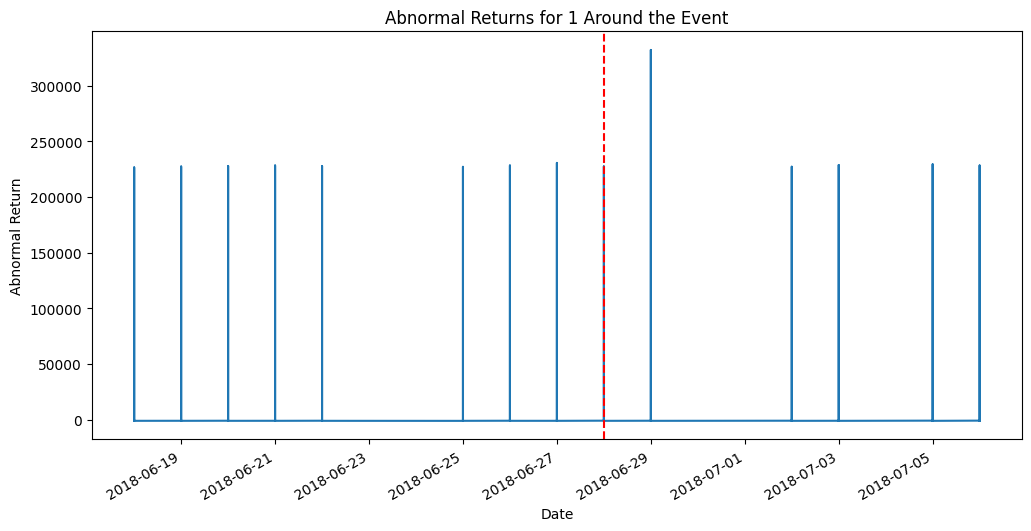

In [11]:

event_date = datetime(2018, 6, 28) # date of CCPA being signed
estimation_window_start = event_date - timedelta(days=365)
print(estimation_window_start)
estimation_window_end = event_date - timedelta(days=30)
event_window_start = event_date - timedelta(days=10)
event_window_end = event_date + timedelta(days=10)

# Calculate daily returns
stock_returns = df['stock_adj_close'].pct_change().dropna()
market_returns = df['market_adj_close'].pct_change().dropna()

# Estimate the market model (CAPM) during the estimation window
estimation_window = (stock_returns.index >= estimation_window_start) & (stock_returns.index <= estimation_window_end)
X = sm.add_constant(market_returns[estimation_window])  # Market returns
y = stock_returns[estimation_window]  # Stock returns
model = sm.OLS(y, X).fit()

# Calculate expected and abnormal returns during the event window
event_window = (stock_returns.index >= event_window_start) & (stock_returns.index <= event_window_end)
expected_returns = model.params[0] + model.params[1] * market_returns[event_window]
abnormal_returns = stock_returns[event_window] - expected_returns

# Output the results
print(abnormal_returns)

# Plotting the abnormal returns
plt.figure(figsize=(12, 6))
abnormal_returns.plot()
plt.title(f'Abnormal Returns for {1} Around the Event')
plt.xlabel('Date')
plt.ylabel('Abnormal Return')
plt.axvline(x=event_date, color='red', linestyle='--')  # Event date line
plt.show()

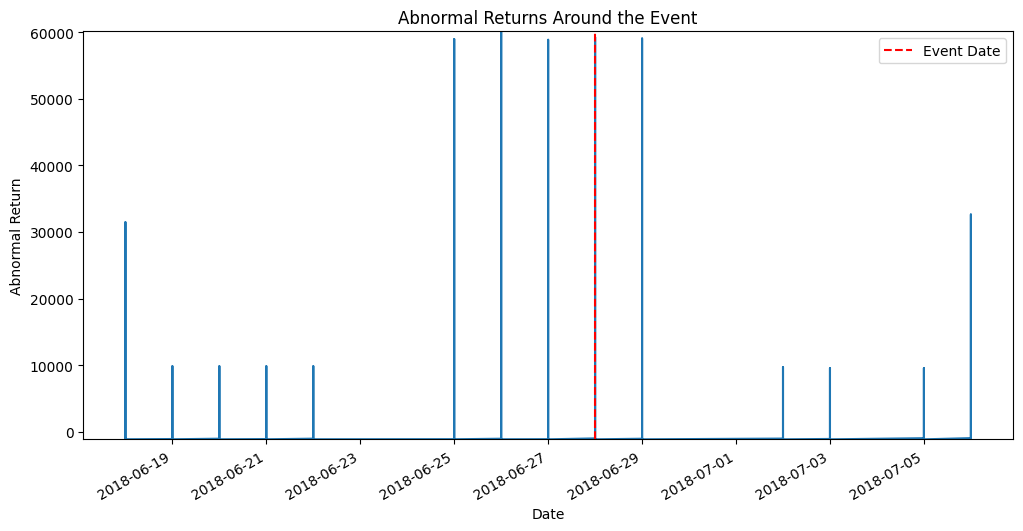

In [12]:


# Assuming you have already calculated `abnormal_returns`

# Filter out extreme values for plotting, you can adjust the threshold as needed
threshold = abnormal_returns.quantile([0.01, 0.99])
filtered_abnormal_returns = abnormal_returns[(abnormal_returns > threshold.iloc[0]) & (abnormal_returns < threshold.iloc[1])]

# Plotting the filtered abnormal returns
plt.figure(figsize=(12, 6))
filtered_abnormal_returns.plot()
plt.title('Abnormal Returns Around the Event')
plt.xlabel('Date')
plt.ylabel('Abnormal Return')

# Add a vertical line for the event date
plt.axvline(x=event_date, color='red', linestyle='--', label='Event Date')

# Add a legend
plt.legend()

# Optionally, set the y-axis limits to a reasonable range based on your data
plt.ylim([filtered_abnormal_returns.min(), filtered_abnormal_returns.max()])

plt.show()


Event study for AAPL:
[*********************100%%**********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-06-28  36.122501  36.527500  35.790001  36.457500  34.216877   88329600
2017-06-29  36.177502  36.282501  35.570000  35.919998  33.712410  125997600
2017-06-30  36.112499  36.240002  35.945000  36.005001  33.792194   92096400
2017-07-03  36.220001  36.325001  35.775002  35.875000  33.670181   57111200
2017-07-05  35.922501  36.197498  35.680000  36.022499  33.808609   86278400
...               ...        ...        ...        ...        ...        ...
2018-06-29  46.572498  46.797501  45.727501  46.277500  44.108509   90950800
2018-07-02  45.955002  46.825001  45.855000  46.794998  44.601757   70925200
2018-07-03  46.947498  46.987499  45.884998  45.980000  43.824959   55819200
2018-07-05  46.314999  46.602501  46.070000  46.349998  44.177612   66416800
2018-07-06  46.355000  47.107498  46.299999  46.992500  44.790005   6994080

C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\54592767.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns = model.params[0] + model.params[1] * market_returns[event_window]
C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\54592767.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns = model.params[0] + model.params[1] * market_returns[event_window]
C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\54592767.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

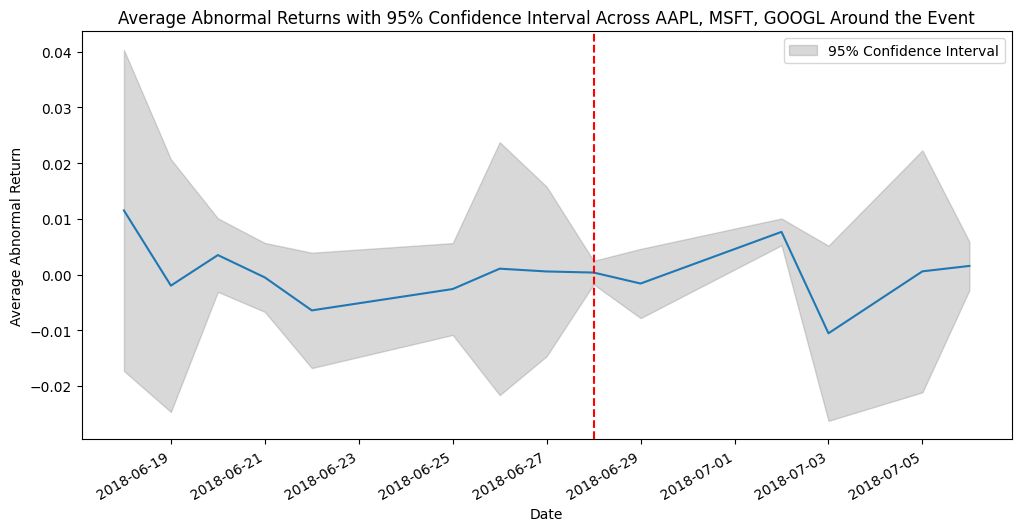

In [17]:

def run_event_study(stock_ticker, event_date):
    # Define the market index
    market_index_ticker = '^GSPC'  # S&P 500

    # Define windows
    estimation_window_start = event_date - timedelta(days=365)
    estimation_window_end = event_date - timedelta(days=30)
    event_window_start = event_date - timedelta(days=10)
    event_window_end = event_date + timedelta(days=10)

    # Fetch historical data
    stock2_data = yf.download(stock_ticker, start=estimation_window_start, end=event_window_end)
    print(stock2_data)
    market_data = yf.download(market_index_ticker, start=estimation_window_start, end=event_window_end)

    # Calculate daily returns
    stock_returns = df['Adj Close'].pct_change().dropna()
    print(df['Adj Close'])
    market_returns = df['Adj Close'].pct_change().dropna()

    # Estimate the market model during the estimation window
    estimation_window = (stock_returns.index >= estimation_window_start) & (stock_returns.index <= estimation_window_end)
    X = sm.add_constant(market_returns[estimation_window])
    y = stock_returns[estimation_window]
    model = sm.OLS(y, X).fit()

    # Calculate expected and abnormal returns during the event window
    event_window = (stock_returns.index >= event_window_start) & (stock_returns.index <= event_window_end)
    expected_returns = model.params[0] + model.params[1] * market_returns[event_window]
    abnormal_returns = stock_returns[event_window] - expected_returns

    # Calculate the average abnormal return
    average_abnormal_return = abnormal_returns.mean()

    # # Plotting
    # plt.figure(figsize=(12, 6))
    # abnormal_returns.plot(title=f'Abnormal Returns for {stock_ticker} Around the Event')
    # plt.axvline(x=event_date, color='red', linestyle='--')  # Event date line
    # plt.axhline(y=average_abnormal_return, color='blue', linestyle='--', label='Average Abnormal Return')  # Average line
    # plt.xlabel('Date')
    # plt.ylabel('Abnormal Return')
    # plt.legend()
    # plt.show()

    # Display the average abnormal return
    print(f"Average Abnormal Return for {stock_ticker}: {average_abnormal_return}")

    return abnormal_returns
# def run_event_study(stock_ticker, event_date):
#     # [Previous code parts remain unchanged]

#     # Return the abnormal returns
#     return abnormal_returns

# Example usage
stock_list = ['AAPL', 'MSFT', 'GOOGL']  # List of stocks to analyze
event_date = datetime(2018, 6, 28)  # Example event date

# Dictionary to hold abnormal returns for each stock
all_abnormal_returns = {}

for stock in stock_list:
    print(f"Event study for {stock}:")
    all_abnormal_returns[stock] = run_event_study(stock, event_date)

# Calculate average abnormal returns across stocks for each day
average_abnormal_returns = pd.concat(all_abnormal_returns, axis=1).mean(axis=1)

# Calculate the standard error of the average abnormal returns
std_error = pd.concat(all_abnormal_returns, axis=1).std(axis=1) / np.sqrt(len(stock_list))

# Determine the t-statistic for a 95% confidence interval
t_stat = t.ppf(1-0.025, df=len(stock_list)-1)

# Calculate the confidence intervals
ci_lower = average_abnormal_returns - (t_stat * std_error)
ci_upper = average_abnormal_returns + (t_stat * std_error)

# Plotting
plt.figure(figsize=(12, 6))
average_abnormal_returns.plot(title='Average Abnormal Returns with 95% Confidence Interval Across AAPL, MSFT, GOOGL Around the Event')
plt.fill_between(average_abnormal_returns.index, ci_lower, ci_upper, color='grey', alpha=0.3, label='95% Confidence Interval')
plt.axvline(x=event_date, color='red', linestyle='--')  # Event date line
plt.xlabel('Date')
plt.ylabel('Average Abnormal Return')
plt.legend()
plt.show()


In [ ]:
import yfinance as yf

# Define the ticker symbol for the company you're interested in
ticker_symbol = 'AAPL'  # Example for Apple Inc.

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Get company information including sector
company_info = ticker.info

# Get stock price (using the closing price of the latest trading day)
stock_price = company_info.get('previousClose')

# Get the sector
company_sector = company_info.get('sector')

print(f"Company: {ticker_symbol}")
print(f"Sector: {company_sector}")
print(f"Stock Price: {stock_price}")


In [ ]:
# Calculate daily returns
stock_returns = stock_data['Adj Close'].pct_change().dropna()
market_returns = market_data['Adj Close'].pct_change().dropna()

# Estimate the market model (CAPM) during the estimation window
estimation_window = (stock_returns.index >= estimation_window_start) & (stock_returns.index <= estimation_window_end)
X = sm.add_constant(market_returns[estimation_window])  # Market returns
y = stock_returns[estimation_window]  # Stock returns
model = sm.OLS(y, X).fit()

# Calculate expected and abnormal returns during the event window
event_window = (stock_returns.index >= event_window_start) & (stock_returns.index <= event_window_end)
expected_returns = model.params[0] + model.params[1] * market_returns[event_window]
abnormal_returns = stock_returns[event_window] - expected_returns

# Output the results
print(abnormal_returns)

# Plotting the abnormal returns
plt.figure(figsize=(12, 6))
abnormal_returns.plot()
plt.title(f'Abnormal Returns for {stock_ticker} Around the Event')
plt.xlabel('Date')
plt.ylabel('Abnormal Return')
plt.axvline(x=event_date, color='red', linestyle='--')  # Event date line
plt.show()

In [ ]:

# Define the stock and market index
stock_ticker = 'AAPL'  # Example: Apple Inc.
market_index_ticker = '^GSPC'  # Example: S&P 500

# Define the event date and windows
event_date = datetime(2020, 1, 1)
estimation_window_start = event_date - timedelta(days=365)
estimation_window_end = event_date - timedelta(days=30)
event_window_start = event_date - timedelta(days=10)
event_window_end = event_date + timedelta(days=10)

# Fetch historical data
stock_data = yf.download(stock_ticker, start=estimation_window_start, end=event_window_end)
market_data = yf.download(market_index_ticker, start=estimation_window_start, end=event_window_end)





In [ ]:

def run_event_study(stock_ticker, event_date):
    # # Define the market index
    # market_index_ticker = '^GSPC'  # S&P 500

    # # Define windows
    # estimation_window_start = event_date - timedelta(days=365)
    # estimation_window_end = event_date - timedelta(days=30)
    # event_window_start = event_date - timedelta(days=10)
    # event_window_end = event_date + timedelta(days=10)

    # # Fetch historical data
    # stock_data = yf.download(stock_ticker, start=estimation_window_start, end=event_window_end)
    # stock_data['Ticker'] = stock_ticker
    # market_data = yf.download(market_index_ticker, start=estimation_window_start, end=event_window_end)
    # stock_data.to_csv('stock_data.csv')
    # market_data.to_csv('market_data.csv')

    estimation_window_start = event_date - timedelta(days=365)
    estimation_window_end = event_date - timedelta(days=30)
    event_window_start = event_date - timedelta(days=10)
    event_window_end = event_date + timedelta(days=10)

    # Fetch historical data for the stock
    stock_data = yf.download(stock_ticker, start=estimation_window_start, end=event_window_end)
    stock_data['Ticker'] = stock_ticker

    # Save the stock data to a CSV file
    stock_data.to_csv('stock_data.csv')

    # Calculate daily returns
    stock_returns = stock_data['Adj Close'].pct_change().dropna()
    market_returns = market_data['Adj Close'].pct_change().dropna()

    # Estimate the market model during the estimation window
    estimation_window = (stock_returns.index >= estimation_window_start) & (stock_returns.index <= estimation_window_end)
    X = sm.add_constant(market_returns[estimation_window])
    y = stock_returns[estimation_window]
    model = sm.OLS(y, X).fit()

    # Calculate expected and abnormal returns during the event window
    event_window = (stock_returns.index >= event_window_start) & (stock_returns.index <= event_window_end)
    expected_returns = model.params[0] + model.params[1] * market_returns[event_window]
    abnormal_returns = stock_returns[event_window] - expected_returns

    # Calculate the average abnormal return
    average_abnormal_return = abnormal_returns.mean()

    # # Plotting
    # plt.figure(figsize=(12, 6))
    # abnormal_returns.plot(title=f'Abnormal Returns for {stock_ticker} Around the Event')
    # plt.axvline(x=event_date, color='red', linestyle='--')  # Event date line
    # plt.axhline(y=average_abnormal_return, color='blue', linestyle='--', label='Average Abnormal Return')  # Average line
    # plt.xlabel('Date')
    # plt.ylabel('Abnormal Return')
    # plt.legend()
    # plt.show()

    # Display the average abnormal return
    print(f"Average Abnormal Return for {stock_ticker}: {average_abnormal_return}")

    return abnormal_returns
# def run_event_study(stock_ticker, event_date):
#     # [Previous code parts remain unchanged]

#     # Return the abnormal returns
#     return abnormal_returns


stock_list = ['ATUS', 'AFTM', 'ATUS']  # List of stocks to analyze
event_date = datetime(2018, 6, 28)  # Example event date


all_abnormal_returns = {}

for stock in stock_list:
    print(f"Event study for {stock}:")
    all_abnormal_returns[stock] = run_event_study(stock, event_date)


average_abnormal_returns = pd.concat(all_abnormal_returns, axis=1).mean(axis=1)


std_error = pd.concat(all_abnormal_returns, axis=1).std(axis=1) / np.sqrt(len(stock_list))

# Determine the t-statistic for a 95% confidence interval
t_stat = t.ppf(1-0.025, df=len(stock_list)-1)

# Calculate the confidence intervals
ci_lower = average_abnormal_returns - (t_stat * std_error)
ci_upper = average_abnormal_returns + (t_stat * std_error)

# Plotting
plt.figure(figsize=(12, 6))
average_abnormal_returns.plot(title='Average Abnormal Returns with 95% Confidence Interval Across AAPL, MSFT, GOOGL Around the Event')
plt.fill_between(average_abnormal_returns.index, ci_lower, ci_upper, color='grey', alpha=0.3, label='95% Confidence Interval')
plt.axvline(x=event_date, color='red', linestyle='--')  # Event date line
plt.xlabel('Date')
plt.ylabel('Average Abnormal Return')
plt.legend()
plt.show()
